In [1]:
import xarray as xr
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import skill_metrics as sm
# import proplot as pplt

# 泰勒图绘制

2021.08.15

计算年际变化（时间序列）的taylor 图

2021.08.16

继续使用skillmetics包进行

将数据处理为字典，便于按照某个特征进行索引

泰勒图上的每个小点会单独绘制，按照特征给予不同的风格

2021.08.25

绘制整个空间上的taylor图，辅助空间pattern说明平均态下的各个统计指标的情况

修改到温度，最大最小平均range，四个指标？

## 数据读入

读入分区之后的数据

In [3]:
dir_in = "/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA/mask_t2m/mask_res/"
filename_obs  = "mask_sel_CN05.1_Tm_1961_2018_daily_025x025.nc"
filename_vr     = "mask_mean_t2m_98-17_VR.nc"
filename_rcm    = "mask_mean_t2m_98-17_RCM.nc"

# 平均气温
ds_or = {}
ds_or['obs'] = xr.open_dataset(dir_in + filename_obs)
ds_or['vr']     = xr.open_dataset(dir_in + filename_vr)
ds_or['rcm']    = xr.open_dataset(dir_in + filename_rcm  )
# 提取变量
var = {}
var['obs'] = ds_or['obs']['tm']#[:,  :, :]
var['vr'] = ds_or['vr']['t2m'] - 273.15
var['rcm'] = ds_or['rcm']['t2m'] - 273.15

# var['obs'] = var['obs'].reset_coords(names = 'lev', drop = True) # 去除掉obs中多余的lev coords

# change coords
var_list = ['obs', 'vr', 'rcm']
for i in var_list:
    rename_dict = dict(zip(var[i].coords.keys(), var['obs'].coords.keys()))
#     # show converting coords
    for rename_i in rename_dict:
        print(rename_i + " -----converting to----- " + rename_dict[rename_i])

    var[i] = var[i].rename(rename_dict)
    var[i]._coords = var['obs']._coords
    var[i] = var[i].rename(i)


# 最高最低气温-温度变动范围
dir_in = "/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA/mask_t2m/mask_res/"

# max temp
filename_obs_max    = "mask_sel_CN05.1_Tmax_1961_2018_daily_025x025.nc"
filename_vr_max     = "mask_max_t2m_98-17_VR.nc"
filename_rcm_max    = "mask_max_t2m_98-17_RCM.nc"

ds_max = {}
ds_max['obs'] = xr.open_dataset(dir_in + filename_obs_max)
ds_max['vr']     = xr.open_dataset(dir_in + filename_vr_max)
ds_max['rcm']    = xr.open_dataset(dir_in + filename_rcm_max)

# min temp
filename_obs_min    = "mask_sel_CN05.1_Tmin_1961_2018_daily_025x025.nc"
filename_vr_min     = "mask_min_t2m_98-17_VR.nc"
filename_rcm_min    = "mask_min_t2m_98-17_RCM.nc"

ds_min = {}
ds_min['obs'] = xr.open_dataset(dir_in + filename_obs_min)
ds_min['vr']     = xr.open_dataset(dir_in + filename_vr_min)
ds_min['rcm']    = xr.open_dataset(dir_in + filename_rcm_min)


# 提取变量 得到温度的变化范围 temp range
var_range = {}
var_range['obs'] = ds_max['obs']['tmax'] - ds_min['obs']['tmin']
var_range['vr'] = ds_max['vr']['t2m'] - ds_min['vr']['t2m']
var_range['rcm'] = ds_max['rcm']['t2m'] - ds_min['vr']['t2m']

# var_range['obs'] = var_range['obs'].reset_coords(names = 'lev', drop = True) # 去除掉obs中多余的lev coords

# change coords
var_range_list = ['obs', 'vr', 'rcm']
for i in var_range_list:
    rename_dict = dict(zip(var_range[i].coords.keys(), var_range['obs'].coords.keys()))
#     # show converting coords
    for rename_i in rename_dict:
        print(rename_i + " -----converting to----- " + rename_dict[rename_i])

    var_range[i] = var_range[i].rename(rename_dict)
    var_range[i]._coords = var_range['obs']._coords
    var_range[i] = var_range[i].rename(i)



time -----converting to----- time
lon -----converting to----- lon
lat -----converting to----- lat
Time -----converting to----- time
longitude -----converting to----- lon
latitude -----converting to----- lat
Time -----converting to----- time
longitude -----converting to----- lon
latitude -----converting to----- lat
time -----converting to----- time
lon -----converting to----- lon
lat -----converting to----- lat
Time -----converting to----- time
longitude -----converting to----- lon
latitude -----converting to----- lat
Time -----converting to----- time
longitude -----converting to----- lon
latitude -----converting to----- lat


In [17]:
### 读入 最大 最小 平均 计算温度范围，将四个量来进行后续泰勒图的绘制

## 计算部分

### 提取指标

In [4]:
var_index_mean = {}
# var_index_mean['am'] = {}
# var_index_mean['jja'] = {}

time_idx = {}
time_idx['am'] = var['obs'].time.dt.month.isin([4,5])
time_idx['jja'] = var['obs'].time.dt.month.isin([6,7,8])

for mod_name in ['obs', 'vr', 'rcm']:
    var_index_mean[mod_name] = {}
    for iseason in ['am','jja']:
        var_index_mean[mod_name][iseason] = {}
        var_selmonth   = var[mod_name].isel(time = time_idx[iseason]) # 选取月份的mod变量，后续通过它计算指标
        range_selmonth = var_range[mod_name].isel(time = time_idx[iseason]) # 选取月份的mod变量，后续通过它计算指标
        var_index_mean[mod_name][iseason]['mean']  = var_selmonth.mean(dim = "time")   # 平均气温的气候态
        var_index_mean[mod_name][iseason]['range'] = range_selmonth.mean(dim = "time") # 气温变化范围的气候态

### 进行泰勒图前处理

将所有数据进行空间pattern的1D化，并且添加到RCM的MASK

In [5]:
# 进行mask，并且整理成1D数组，得到1D-pattern，用于后续的计算
# 计算指数的平均值
var_index_mean_1d = {}

for mod_name in ['obs', 'vr', 'rcm']:
    var_index_mean_1d[mod_name] = {}
    for iseason in ['am','jja']:
        var_index_mean_1d[mod_name][iseason] = {}
        for count_way in ['mean', 'range']:
            var_index_mean_1d[mod_name][iseason][count_way] = {} 
            rcm_not_nan = ~np.isnan(var['rcm'][0,:,:]) # 添加新的nan，rainday经过计算后nan消失
            var_1d_temp = xr.where(rcm_not_nan, var_index_mean[mod_name][iseason][count_way], np.nan).values.ravel()
            var_index_mean_1d[mod_name][iseason][count_way] = var_1d_temp[~np.isnan(var_1d_temp)]

### 计算泰勒图诸要素，并整理进行绘图

In [13]:
# 计算泰勒图诸要素 到字典taylor_ts中


# 进行mask，并且整理成1D数组，得到1D-pattern，用于后续的计算
# 计算指数的平均值
taylor_space = {}

for mod_name in ['obs', 'vr', 'rcm']:
    taylor_space[mod_name] = {}
    for iseason in ['am','jja']:
        taylor_space[mod_name][iseason] = {}
        for count_way in  ['mean', 'range']:
            taylor_space[mod_name][iseason][count_way] = {} 
            temp_obs = var_index_mean_1d['obs'][iseason][count_way]
            temp_mod = var_index_mean_1d[mod_name][iseason][count_way]
            # remove nan
            temp_obs = temp_obs[~np.isnan(temp_obs)]
            temp_mod = temp_mod[~np.isnan(temp_mod)]
            # taylor count
            taylor_space[mod_name][iseason][count_way] = sm.taylor_statistics(temp_mod, temp_obs)
            # normalized
            taylor_space[mod_name][iseason][count_way]['sdev'] = taylor_space[mod_name][iseason][count_way]['sdev'] / taylor_space[mod_name][iseason][count_way]['sdev'][0]
            taylor_space[mod_name][iseason][count_way]['crmsd'] = taylor_space[mod_name][iseason][count_way]['crmsd'] / taylor_space[mod_name][iseason][count_way]['sdev'][0]

## 绘图部分

逐个点的绘制泰勒图，单独为每个点的属性设置相应的特征

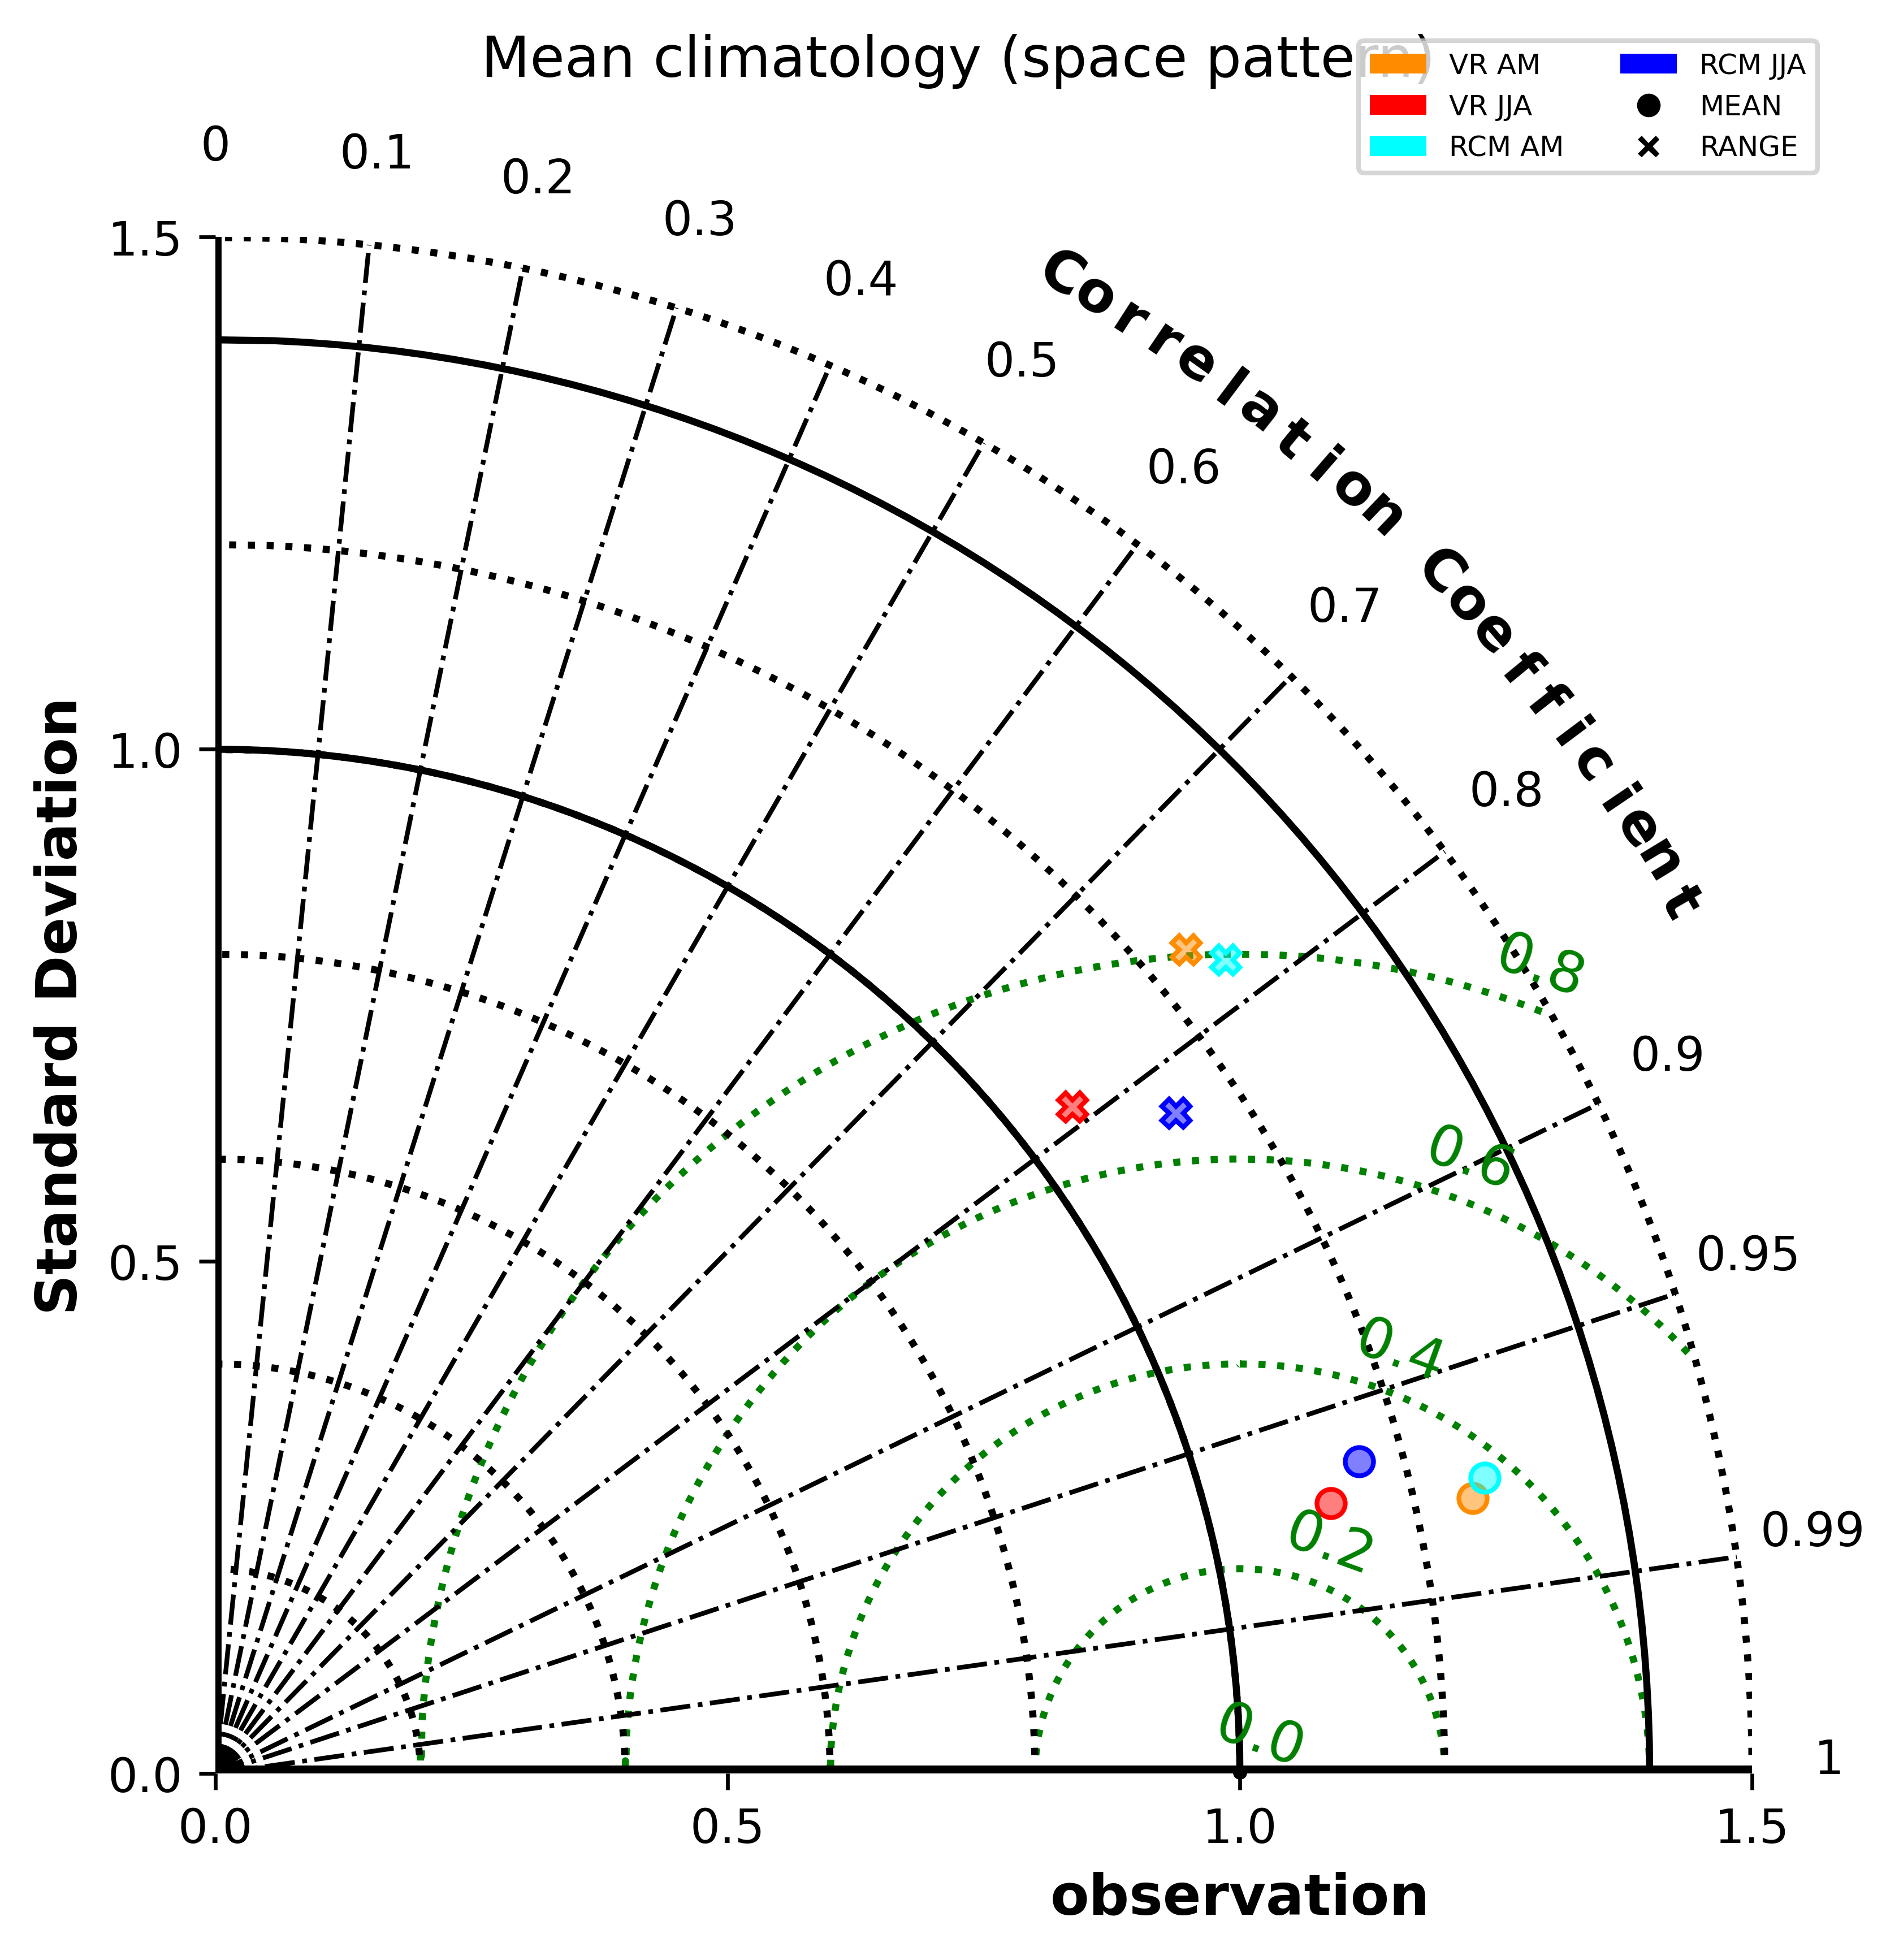

In [16]:
# import skill_metrics as sm
import importlib
importlib.reload(sm)

# fig, axs = pplt.subplots(ncols=1 ,nrows=1)
fig = plt.figure(figsize=(6, 6), dpi=600)

first_plot = False # 用作后续overlay设置

# 创建风格的dict,之后传入每个单独的点来进行绘制
# # Define markers
# kind = ['+','o','x','s','d','^','v','p','h','*']
# colorm = ['b','r','g','c','m','y','k']
imodiseason_color = {'vr am':"darkorange", 'vr jja':"red",'rcm am':'cyan', "rcm jja":"blue"}
# iregion_style_color = {"NE":"m", "NC":"y", "YZ":"c", "SC":"b",'SW':"g",'NWC':"tab:gray"}
# iseason_style_marker = {'am':'.',"jja":'v'}

count_way_marker = {'mean':"o","range":"X"}


for imod in ['vr','rcm']:
    for iseason in ['am','jja']:
        for count_way in ['mean', 'range']:
            # 获取每个点的泰勒图诸要素
            sdev_plot = taylor_space[imod][iseason][count_way]['sdev']
            crmsd_plot = taylor_space[imod][iseason][count_way]['crmsd']
            ccoef_plot = taylor_space[imod][iseason][count_way]['ccoef']

            sm.taylor_diagram(sdev_plot,crmsd_plot,ccoef_plot, 
                #----- mark setting -----
                MarkerDisplayed = 'marker',
                # markerLabel = label2, 
                # numberPanels = 1,
                # markerLabel = ['obs','vr','rcm'],
                # markerLabel = ['obs', imod.upper()],
                # markerLabelColor = imod_style_color[imod],
                markerlegend = "off",
                markerColor = imodiseason_color[imod + " " + iseason],
                # markerColor = 'k',
                markerSize = 6,
                alpha = .5, 
                # -----RNSD-----
                # tickRMS = np.arange(0,1.8,0.2),
                tickRMS = np.arange(0,1.0,0.2),
                tickRMSangle = 70, 
                colRMS = 'g', styleRMS = ':', widthRMS = 1.5,
                # tickCOR = lsCOR,
                showlabelsRMS = "on",
                titleRMS = "off",
                rmslabelformat = ':.1f',
                # -----COR-----
                colCOR = "k", 
                widthCOR = 1.0,
                # -----STD------
                tickSTD = np.arange(0,1.5,0.2), axismax = 1.5, 
                showlabelsSTD = 'on',
                # markersymbol = iseason_style_marker[iseason],
                # markersymbol = combine_mod_season_marker[imod + " " + iseason],
                markersymbol = count_way_marker[count_way],
                # -----marker reference-----
                styleOBS = '-', 
                colOBS = 'k',
                markerobs = 'o', 
                overlay = first_plot,
                titleOBS = 'observation',
                # ------ check -----
                checkStats = True,
            )

            first_plot = True


# legend设置，颜色以及型号
# custom legend
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = []
for i in imodiseason_color.items():
    legend_elements.append( Patch(facecolor=i[1],label=i[0].upper()))
for i in count_way_marker.items():
    legend_elements.append( Line2D([0], [0], marker=i[1], color='w', label=i[0].upper(),linestyle=None,
                          markerfacecolor='k', markersize=6)) 

fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(.9,0.95),prop={'size': 6}, ncol=2)

fig.suptitle("Mean climatology (space pattern)")

#saving pics
plt.savefig("./output_pic/t2m_taylor_space_all",dpi=600, facecolor = 'white')